# Fine-Tunning

Cuando tenemos pocos datos, y además no hay una red especifica que comparta mucho dominio con nuestro caso de uso, podemos hacer fine-tuning a una red ya existente.

El proceso de finetuning consiste en hacer freeze de ciertas capas, y entrenar otras, además de entrenar la cabeza.

Dependiendo de que características queramos quedarnos (mas o menos generales) y del grado de dominio que compartamos entre la red source y nuestro target, haremos freeze de más o menos capas.

En general este es un proceso iterativo, prueba y error.

Las capas iniciales capturan patrones genéricos (bordes, texturas), útiles para casi cualquier tarea.

Las capas profundas capturan rasgos específicos del dataset original, por lo que son las que suele convenir reajustar cuando cambias de dominio.

El fine-tuning siempre incluye:

-  Sustituir la cabeza (head) por una nueva adaptada al nº de clases objetivo.

- Decidir qué capas del backbone se reentrenan y cuáles se congelan.

- Usar una tasa de aprendizaje pequeña (a menudo 10× menor que en entrenamiento desde cero) para no destruir pesos    preentrenados.

Empecemos.

Como hicimos antes, cargamos los pesos de la red VGG16 entranada con IMGNET

In [67]:
from torchvision import models, datasets, transforms
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchsummary import summary

#Obtenemos los pesos de la red VGG16 entrenada en el dataset IMAGENET

weights = models.VGG16_Weights.IMAGENET1K_V1

#Como vemos aqui observamos los valores a los que nuestro dataset debe ser normalizado
# y preprocesado para que la red pueda usarlo.

preprocess = weights.transforms()
print(preprocess)
IMAGENET_MEAN = preprocess.mean
IMAGENET_STD  = preprocess.std

print(IMAGENET_MEAN)
print(IMAGENET_STD)


ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)
[0.485, 0.456, 0.406]
[0.229, 0.224, 0.225]


In [68]:


# Replicamos el pipeline de preprocesado de la red VGG16
base_tf = transforms.Compose([
    transforms.Resize(256, interpolation=transforms.InterpolationMode.BILINEAR), # Redimensiona la imagen
    transforms.CenterCrop(224), # Recorta la imagen
    transforms.ToTensor(), # Convierte la imagen a un tensor
    transforms.Normalize(weights.transforms().mean, weights.transforms().std), # Normaliza la imagen
])

root = "./data/02"
train_ds = datasets.ImageFolder(f"{root}/train", transform=base_tf)
valid_ds = datasets.ImageFolder(f"{root}/valid", transform=base_tf)
test_ds  = datasets.ImageFolder(f"{root}/test",  transform=base_tf)

loader_train = DataLoader(train_ds, batch_size=64, shuffle=True)                       
loader_val   = DataLoader(valid_ds, batch_size=64, shuffle=False)
loader_test  = DataLoader(test_ds,  batch_size=64,  shuffle=False)


In [69]:
# Definimos GPU o CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Obtenemos el numero de clases de nuestro dataset
num_classes = len(train_ds.classes)
print(num_classes)

# Definimos la base de la red VGG16
base = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1).to(device)


#Vamos a imprimir los parametros de la red VGG16
# Calculamos parámetros
trainable_params = sum(p.numel() for p in base.parameters() if p.requires_grad)
total_params     = sum(p.numel() for p in base.parameters())
frozen_params    = total_params - trainable_params

print(f"Trainable: {trainable_params:,} | Frozen: {frozen_params:,} | Total: {total_params:,}")



10
Trainable: 138,357,544 | Frozen: 0 | Total: 138,357,544


Vamos a congelar las capas de la red VGG16, quitar el head y sustituir la última capa avg pool 7×7 por una avg pool 1×1.
Esto reduce el número de parámetros de la cabeza y, por tanto, la probabilidad de overfitting.

En el ejercicio anterior, sin este ajuste, se observó un leve overfitting; en este caso, al afinar más capas del backbone, aplicamos este cambio para mantener el modelo más controlado y estable.

In [70]:

# Congelamos los parametros de la red VGG16
# Aqui le decimos que no calcule los gradientes para los parametros de la red VGG16
# Esto es importante, ya que si no lo hacemos, el modelo se entrenará desde cero
# y no aprovechará los pesos ya entrenados de la red VGG16-Imagenet
for p in base.features.parameters():
    p.requires_grad = False


# Vamos a volver a calcular los parametros de la red VGG16, para ver que se han congelado
# Calculamos parámetros
trainable_params = sum(p.numel() for p in base.parameters() if p.requires_grad)
total_params     = sum(p.numel() for p in base.parameters())
frozen_params    = total_params - trainable_params

print(f"Trainable: {trainable_params:,} | Frozen: {frozen_params:,} | Total: {total_params:,}")


#Quitamos el head de la red VGG16
backbone = nn.Sequential(*(list(base.children())[:-1]))

# Modificamos la ultima capa de la red para que sea una capa global average pooling
backbone[-1] = nn.AdaptiveAvgPool2d((1, 1))

# Vemos que los parametros entrenables se han reducido a 0
trainable_params = sum(p.numel() for p in backbone.parameters() if p.requires_grad)
total_params     = sum(p.numel() for p in backbone.parameters())
frozen_params    = total_params - trainable_params

print(f"Trainable: {trainable_params:,} | Frozen: {frozen_params:,} | Total: {total_params:,}")

print(summary(backbone, (3, 224, 224)))

Trainable: 123,642,856 | Frozen: 14,714,688 | Total: 138,357,544
Trainable: 0 | Frozen: 14,714,688 | Total: 14,714,688
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56] 

Vamos a imprimir los indices y los tipos de las capas que tenemos para saber cuales tenemos que descongelar.

In [71]:
for i, layer in enumerate(base.features):
    # comprobamos si alguno de los parámetros de la capa tiene gradiente activado
    requires_grad = any(p.requires_grad for p in layer.parameters())
    print(f"{i:02d}: {layer.__class__.__name__:<20} | requires_grad={requires_grad}")


00: Conv2d               | requires_grad=False
01: ReLU                 | requires_grad=False
02: Conv2d               | requires_grad=False
03: ReLU                 | requires_grad=False
04: MaxPool2d            | requires_grad=False
05: Conv2d               | requires_grad=False
06: ReLU                 | requires_grad=False
07: Conv2d               | requires_grad=False
08: ReLU                 | requires_grad=False
09: MaxPool2d            | requires_grad=False
10: Conv2d               | requires_grad=False
11: ReLU                 | requires_grad=False
12: Conv2d               | requires_grad=False
13: ReLU                 | requires_grad=False
14: Conv2d               | requires_grad=False
15: ReLU                 | requires_grad=False
16: MaxPool2d            | requires_grad=False
17: Conv2d               | requires_grad=False
18: ReLU                 | requires_grad=False
19: Conv2d               | requires_grad=False
20: ReLU                 | requires_grad=False
21: Conv2d   

In [72]:
# Descongelamos las últimas 3 capas convolucionales  (solo esas 3 tienen pesos: block5_conv1-3)
for idx in [24, 26, 28]:
    for p in backbone[0][idx].parameters():
        p.requires_grad = True


for i, layer in enumerate(base.features):
    # comprobamos si alguno de los parámetros de la capa tiene gradiente activado
    requires_grad = any(p.requires_grad for p in layer.parameters())
    print(f"{i:02d}: {layer.__class__.__name__:<20} | requires_grad={requires_grad}")


00: Conv2d               | requires_grad=False
01: ReLU                 | requires_grad=False
02: Conv2d               | requires_grad=False
03: ReLU                 | requires_grad=False
04: MaxPool2d            | requires_grad=False
05: Conv2d               | requires_grad=False
06: ReLU                 | requires_grad=False
07: Conv2d               | requires_grad=False
08: ReLU                 | requires_grad=False
09: MaxPool2d            | requires_grad=False
10: Conv2d               | requires_grad=False
11: ReLU                 | requires_grad=False
12: Conv2d               | requires_grad=False
13: ReLU                 | requires_grad=False
14: Conv2d               | requires_grad=False
15: ReLU                 | requires_grad=False
16: MaxPool2d            | requires_grad=False
17: Conv2d               | requires_grad=False
18: ReLU                 | requires_grad=False
19: Conv2d               | requires_grad=False
20: ReLU                 | requires_grad=False
21: Conv2d   

In [73]:
# Imprimimos los parametros de la red VGG16 una vez descongeladas las 3 capas convolucionales
trainable_params = sum(p.numel() for p in backbone.parameters() if p.requires_grad)
total_params     = sum(p.numel() for p in backbone.parameters())
frozen_params    = total_params - trainable_params

print(f"Trainable: {trainable_params:,} | Frozen: {frozen_params:,} | Total: {total_params:,}")



Trainable: 7,079,424 | Frozen: 7,635,264 | Total: 14,714,688


Definamos el clasificador

In [74]:

# Definimos el clasificador
head = nn.Sequential(
    nn.Flatten(),
    nn.Linear(512, 10), # 512 es el numero de features de la ultima capa de convolución y 1*1 es el tamaño de la imagen de entrada.
                        #En este caso no tiene sentido poner 1*1 ya que el resultado sería el mismo.
    #No añadimos activacion al final, ya que usaremos CrossEntropyLoss que aplica la activacion softmax.
)

Juntemos ahora el backbone + el head

In [75]:
class VGG16FineTunning(nn.Module):
    def __init__(self, backbone, head):
        super().__init__()
        self.backbone = backbone
        self.head = head

    def forward(self, x):
        x = self.backbone(x)
        x = self.head(x)
        return x

model = VGG16FineTunning(backbone, head).to(device)

print(summary(model, (3, 224, 224)))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [76]:
#Se optimiza solo las capas no congeladas + el clasificador.
import torch.optim as optim
from datetime import datetime
from torchmetrics.classification import MulticlassPrecision, MulticlassRecall, MulticlassF1Score

NUM_CLASSES = 10
EPOCHS = 20
TENSORBOARD_EXP = f"runs/vgg16_imgnet_10cls_finetunning_{datetime.now().strftime('%Y%m%d-%H%M%S')}"
precision_metric = MulticlassPrecision(num_classes=NUM_CLASSES, average="macro").to(device)
recall_metric    = MulticlassRecall(num_classes=NUM_CLASSES, average="macro").to(device)
f1_metric        = MulticlassF1Score(num_classes=NUM_CLASSES, average="macro").to(device)

#Seleccionamos los parametros que se van a optimizar, solo required_grad = True
params = (p for p in model.parameters() if p.requires_grad==True)

optimizer = optim.Adam(params, lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params     = sum(p.numel() for p in model.parameters())
frozen_params    = total_params - trainable_params
print(f"Trainable: {trainable_params:,} | Frozen: {frozen_params:,} | Total: {total_params:,}")

print([n for n, p in model.named_parameters() if p.requires_grad][:8])


Trainable: 7,084,554 | Frozen: 7,635,264 | Total: 14,719,818
['backbone.0.24.weight', 'backbone.0.24.bias', 'backbone.0.26.weight', 'backbone.0.26.bias', 'backbone.0.28.weight', 'backbone.0.28.bias', 'head.1.weight', 'head.1.bias']


In [77]:
from torch.utils.tensorboard import SummaryWriter
import torch

writer = SummaryWriter(log_dir=TENSORBOARD_EXP)

def evaluate(model, loader, device, criterion):
    model.eval()
    total, correct, total_loss = 0, 0, 0.0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            loss = criterion(logits, labels)
            total_loss += loss.item() * images.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return total_loss / total, correct / total



train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in loader_train:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad(set_to_none=True)
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total
    val_loss, val_acc = evaluate(model, loader_val, device, criterion)

    precision_metric.reset(); recall_metric.reset(); f1_metric.reset()
    with torch.no_grad():
        for images, labels in loader_val:
            images, labels = images.to(device), labels.to(device)
            preds = model(images).argmax(dim=1)
            precision_metric.update(preds, labels)
            recall_metric.update(preds, labels)
            f1_metric.update(preds, labels)
    precision_val = precision_metric.compute().item()
    recall_val    = recall_metric.compute().item()
    f1_val        = f1_metric.compute().item()

    writer.add_scalar("Val/Precision_macro", precision_val, epoch)
    writer.add_scalar("Val/Recall_macro",    recall_val,  epoch)
    writer.add_scalar("Val/F1_macro",        f1_val,      epoch)

    train_losses.append(train_loss); val_losses.append(val_loss)
    train_accuracies.append(train_acc); val_accuracies.append(val_acc)

    print(f"Época {epoch}/{EPOCHS} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("Loss/val",   val_loss,  epoch)
    writer.add_scalar("Acc/train",  train_acc, epoch)
    writer.add_scalar("Acc/val",    val_acc,   epoch)
    writer.add_scalar("LR", optimizer.param_groups[0]['lr'], epoch)
    writer.flush()

test_loss, test_acc = evaluate(model, loader_test, device, criterion)

hparams = {
    'model': model.__class__.__name__,
    'seed': 3,
    'optimizer': optimizer.__class__.__name__,
    'lr_init': float(optimizer.param_groups[0]['lr']),
    'batch_size': int(loader_train.batch_size),
}

metrics = {
    'metrics/test_acc': float(test_acc),
    'metrics/test_loss': float(test_loss),
    'metrics/val_acc_last': float(val_accuracies[-1]),
    'metrics/val_loss_last': float(val_losses[-1]),
    'metrics/train_acc_last': float(train_accuracies[-1]),
    'metrics/train_loss_last': float(train_losses[-1]),
}

writer.add_hparams(hparams, metrics)
writer.close()


Época 1/20 | Train Loss: 1.5506 | Train Acc: 0.5380 | Val Loss: 0.5733 | Val Acc: 0.8933
Época 2/20 | Train Loss: 0.3228 | Train Acc: 0.9311 | Val Loss: 0.2490 | Val Acc: 0.9400
Época 3/20 | Train Loss: 0.1163 | Train Acc: 0.9761 | Val Loss: 0.1452 | Val Acc: 0.9667
Época 4/20 | Train Loss: 0.0541 | Train Acc: 0.9912 | Val Loss: 0.1243 | Val Acc: 0.9733
Época 5/20 | Train Loss: 0.0266 | Train Acc: 0.9982 | Val Loss: 0.1072 | Val Acc: 0.9700
Época 6/20 | Train Loss: 0.0146 | Train Acc: 0.9994 | Val Loss: 0.1103 | Val Acc: 0.9800
Época 7/20 | Train Loss: 0.0089 | Train Acc: 1.0000 | Val Loss: 0.1116 | Val Acc: 0.9800
Época 8/20 | Train Loss: 0.0068 | Train Acc: 1.0000 | Val Loss: 0.0920 | Val Acc: 0.9867
Época 9/20 | Train Loss: 0.0043 | Train Acc: 1.0000 | Val Loss: 0.0946 | Val Acc: 0.9833
Época 10/20 | Train Loss: 0.0030 | Train Acc: 1.0000 | Val Loss: 0.1062 | Val Acc: 0.9833
Época 11/20 | Train Loss: 0.0022 | Train Acc: 1.0000 | Val Loss: 0.0968 | Val Acc: 0.9800
Época 12/20 | Train

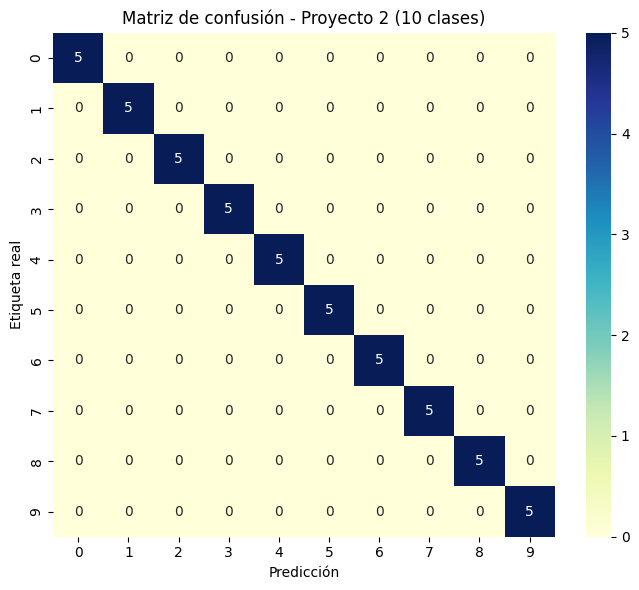

In [78]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch

model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for x, y in loader_test:
        x, y = x.to(device), y.to(device)
        preds = model(x).argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds, labels=list(range(len(train_ds.classes))))
classes = train_ds.classes

plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu",
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicción")
plt.ylabel("Etiqueta real")
plt.title("Matriz de confusión - Proyecto 2 (10 clases)")
plt.tight_layout()
plt.show()
